In [4]:
# Cell 1: imports & paths
import os
import re
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn for n-grams
from sklearn.feature_extraction.text import CountVectorizer

# Allow PIL to load truncated images (sometimes useful)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Paths
BASE_PATH = r"C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource"
DATA_PATH = os.path.join(BASE_PATH, "dataset")
IMAGE_PATH = os.path.join(BASE_PATH, "images", "train")   # where images are saved as <sample_id>.jpg
os.makedirs(IMAGE_PATH, exist_ok=True)

print("BASE_PATH:", BASE_PATH)
print("DATA_PATH:", DATA_PATH)
print("IMAGE_PATH:", IMAGE_PATH)


BASE_PATH: C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource
DATA_PATH: C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource\dataset
IMAGE_PATH: C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource\images\train


In [5]:
# Cell 2: load data
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

# Ensure price numeric and basic info
train_df['price'] = pd.to_numeric(train_df['price'], errors='coerce')
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Nulls in train:\n", train_df.isnull().sum())
train_df.head()


Train shape: (75000, 4)
Test shape: (75000, 3)
Nulls in train:
 sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


C:\Users\anoushka chatterjee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\anoushka chatterjee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


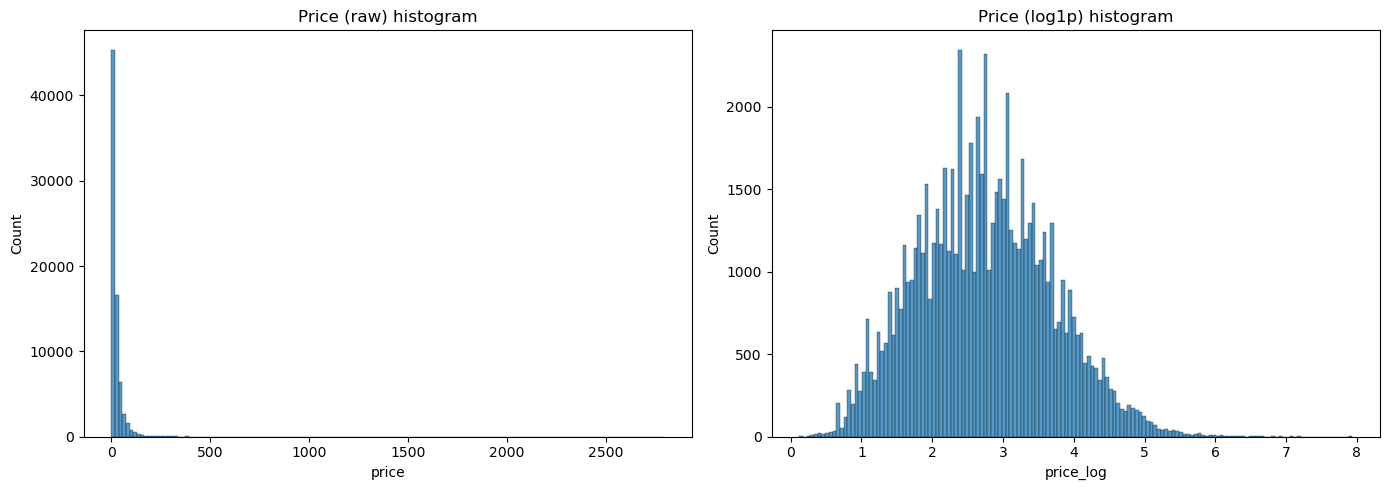

In [6]:
# Cell 5: price histograms and log1p transform
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(train_df['price'].dropna(), bins=150, kde=False)
plt.title("Price (raw) histogram")
plt.xlabel("price")

plt.subplot(1,2,2)
train_df['price_log'] = np.log1p(train_df['price'])
sns.histplot(train_df['price_log'].dropna(), bins=150, kde=False)
plt.title("Price (log1p) histogram")
plt.xlabel("price_log")
plt.tight_layout()
plt.show()


In [7]:
# Cell 6: mark outliers with multiple heuristics
# percentiles
p001 = train_df['price'].quantile(0.001)
p01  = train_df['price'].quantile(0.01)
p99  = train_df['price'].quantile(0.99)
p999 = train_df['price'].quantile(0.999)
iqr = train_df['price'].quantile(0.75) - train_df['price'].quantile(0.25)
upper_3iqr = train_df['price'].quantile(0.75) + 3*iqr

train_df['out_low_001'] = train_df['price'] < p001
train_df['out_high_999'] = train_df['price'] > p999
train_df['out_above_3iqr'] = train_df['price'] > upper_3iqr
train_df['price_is_positive'] = train_df['price'] > 0

print("Counts of flags:", train_df['out_low_001'].sum(), train_df['out_high_999'].sum(), train_df['out_above_3iqr'].sum(), (~train_df['price_is_positive']).sum())

# Show some extreme examples
display(train_df.sort_values('price', ascending=False).head(10)[['sample_id','price','catalog_content']])
display(train_df[train_df['price'] <= 0].head(10)[['sample_id','price','catalog_content']])


Counts of flags: 75 75 2238 0


,sample_id,price,catalog_content
58617,229126,2796.00,Item Name: 4Patriots 1-Year Survival Food Kit:...
32153,134909,1280.00,Item Name: Royal Amber Osetra Caviar - Russian...
22839,62251,1188.00,Item Name: 495 days proteins meal 33 bottles x...
46301,195806,1010.54,Item Name: China Beauty Rings Tea (Loose) (8 o...
68388,236048,921.50,"Item Name: Organic Pistachios Shelled Raw, 30 ..."
72853,262694,779.25,Item Name: Numanna Family Pack Bucket 432 Serv...
73067,190026,739.99,"Item Name: Crystal Geyser Pallet Of 84 Cases, ..."
45580,272914,691.16,"Item Name: Topps Juicy Drop Pop, 18 count per ..."
56075,227791,679.92,Item Name: Alex's Low Acid Organic Coffee Ulti...
4146,46413,613.58,Item Name: Beverage/Topping Heated Condiment D...


,sample_id,price,catalog_content


In [8]:
# Cell 7: winsorize/clipping recommended (you can comment out if you prefer to keep raw)
LOW_PCT = 0.001
HIGH_PCT = 0.999
lower_cut = train_df['price'].quantile(LOW_PCT)
upper_cut = train_df['price'].quantile(HIGH_PCT)
print("Clipping bounds:", lower_cut, upper_cut)

train_df['price_winsor'] = train_df['price'].clip(lower=lower_cut, upper=upper_cut)
train_df['price_target'] = np.log1p(train_df['price_winsor'])  # this is the target we will model
# If you prefer raw log1p, replace above with np.log1p(train_df['price'])

# Quick check
print(train_df[['price','price_winsor','price_target']].describe().T)


Clipping bounds: 0.659995 322.1217400000067
                count       mean        std       min       25%       50%  \
price         75000.0  23.647654  33.376932  0.130000  6.795000  14.00000   
price_winsor  75000.0  23.471665  29.553839  0.659995  6.795000  14.00000   
price_target  75000.0   2.738992   0.940501  0.506815  2.053483   2.70805   

                    75%          max  
price         28.625000  2796.000000  
price_winsor  28.625000   322.121740  
price_target   3.388619     5.778029  


In [9]:
# Cell 8: text parsing & IPQ extraction
def extract_ipq(text):
    if pd.isna(text): 
        return np.nan
    s = str(text).lower()
    # try common patterns: "pack of 12", "12 pack", "12 pcs", "pack(12)", "case of 12", "12-count"
    patterns = [
        r'pack\s*(?:of)?\s*(\d{1,4})',
        r'(\d{1,4})\s*(?:pack|packs|pcs|pieces|ctn|count|pk|packet|bundle|units)\b',
        r'(\d{1,4})\s*-\s*count',
        r'(\d{1,4})\s*ctn',
        r'case\s*of\s*(\d{1,4})',
        r'(\d{1,4})\s*x\s*\d{1,4}'  # e.g., "3 x 200g" -> capture 3 (but ambiguous)
    ]
    for pat in patterns:
        m = re.search(pat, s)
        if m:
            try:
                val = int(m.group(1))
                # sanity bounds
                if 1 <= val <= 10000:
                    return val
            except:
                pass
    return np.nan

train_df['ipq'] = train_df['catalog_content'].apply(extract_ipq)
test_df['ipq']  = test_df['catalog_content'].apply(extract_ipq)

# fallback: fill missing ipq with 1 (conservative) or median
train_df['ipq_filled'] = train_df['ipq'].fillna(1).astype(int)
test_df['ipq_filled']  = test_df['ipq'].fillna(1).astype(int)

# text length features
for df in [train_df, test_df]:
    df['catalog_len'] = df['catalog_content'].fillna("").str.len()
    df['catalog_word_count'] = df['catalog_content'].fillna("").apply(lambda s: len(str(s).split()))

# keywords
keywords = ['bundle','pack','premium','refurbished','genuine','original','set','combo']
for kw in keywords:
    train_df[f'kw_{kw}'] = train_df['catalog_content'].fillna("").str.contains(kw, case=False).astype(int)
    test_df[f'kw_{kw}']  = test_df['catalog_content'].fillna("").str.contains(kw, case=False).astype(int)

train_df[['sample_id','ipq','ipq_filled','catalog_len','catalog_word_count']].head()


,sample_id,ipq,ipq_filled,catalog_len,catalog_word_count
0,33127,6.0,6,91,18
1,198967,4.0,4,511,80
2,261251,6.0,6,328,59
3,55858,NaN,1,1318,211
4,292686,NaN,1,155,28


In [10]:
# Cell 9: top unigrams and bigrams in titles/descriptions (train)
corpus = train_df['catalog_content'].fillna("").astype(str).tolist()
# Use CountVectorizer to get top n-grams
cv = CountVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')
X = cv.fit_transform(corpus)
features = np.array(cv.get_feature_names_out())
sums = np.array(X.sum(axis=0)).ravel()
top_idx = np.argsort(sums)[::-1][:50]
top_terms = list(zip(features[top_idx], sums[top_idx]))
pd.DataFrame(top_terms, columns=['term','count']).head(20)


,term,count
0,point,267979
1,bullet,267690
2,bullet point,267675
3,value,78935
4,item,77872
5,unit,75623
6,tea,70090
7,ounce,64031
8,free,62220
9,oz,56529


In [13]:
# Cell A: create image_path columns for train and test (if missing)
import os

# Ensure IMAGE_PATH exists (should already)
os.makedirs(IMAGE_PATH, exist_ok=True)

# Add image_path columns if not present
if 'image_path' not in train_df.columns:
    train_df['image_path'] = train_df['sample_id'].apply(lambda sid: os.path.join(IMAGE_PATH, f"{sid}.jpg"))

if 'image_path' not in test_df.columns:
    test_df['image_path'] = test_df['sample_id'].apply(lambda sid: os.path.join(IMAGE_PATH, f"{sid}.jpg"))

# Quick check
print("train_df columns contains image_path?:", 'image_path' in train_df.columns)
print("Example image_path:", train_df['image_path'].iloc[0])


train_df columns contains image_path?: True
Example image_path: C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource\images\train\33127.jpg


In [14]:
# Cell B: check file existence, then validate files by trying to open them with PIL.
# Uses ThreadPoolExecutor (safer on Windows notebooks than multiprocessing.Pool).

from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image, ImageFile
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True

def check_and_validate(path_tuple):
    sample_id, path = path_tuple
    exists = os.path.exists(path)
    if not exists:
        return (sample_id, path, False, False, None, None, None)
    try:
        with Image.open(path) as im:
            im = im.convert('RGB')
            arr = np.array(im)
            h, w = arr.shape[0], arr.shape[1]
            mean_px = float(arr.mean())
            std_px  = float(arr.std())
        return (sample_id, path, True, True, w, h, mean_px, std_px)
    except Exception as e:
        # file exists but failed to open/validate
        return (sample_id, path, True, False, None, None, None, None)

# Build list of items to validate (train)
items = list(zip(train_df['sample_id'], train_df['image_path']))

# Choose number of workers (don't set too high)
max_workers = min(12, (os.cpu_count() or 4) * 2)

results = []
with ThreadPoolExecutor(max_workers=max_workers) as exe:
    futures = {exe.submit(check_and_validate, it): it for it in items}
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Validating images"):
        try:
            results.append(fut.result())
        except Exception as e:
            # capture unexpected failure
            item = futures[fut]
            results.append((item[0], item[1], False, False, None, None, None, None))

# Convert results to DataFrame
cols = ['sample_id','image_path_checked','file_exists','valid','width','height','mean_pixel','std_pixel']
img_check_df = pd.DataFrame(results, columns=cols)

# Merge back into train_df (ensure no duplicate column names)
train_df = train_df.merge(img_check_df, on='sample_id', how='left')

# Create convenience flags
train_df['has_image'] = train_df['file_exists'].fillna(False).astype(int)
train_df['image_valid'] = train_df['valid'].fillna(False).astype(int)

print("Total images found (exists):", int(train_df['has_image'].sum()), "/", len(train_df))
print("Total valid images (opened successfully):", int(train_df['image_valid'].sum()), "/", len(train_df))


Validating images: 100%|███████████████████████████████████████████████████████| 75000/75000 [2:40:48<00:00,  7.77it/s]


Total images found (exists): 74999 / 75000
Total valid images (opened successfully): 74999 / 75000


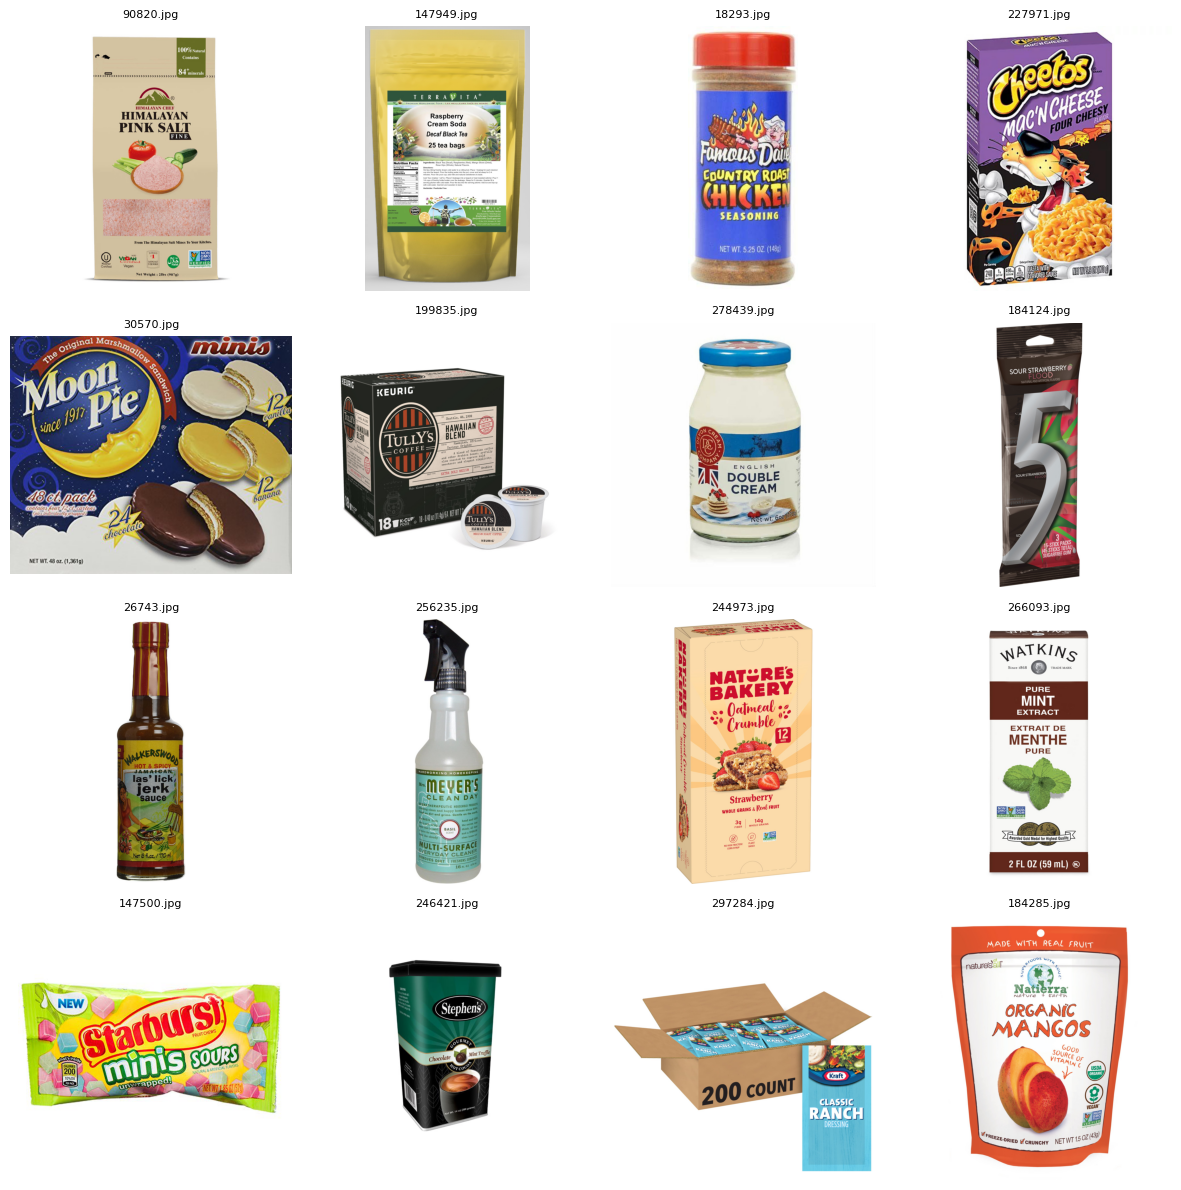

In [15]:
# Cell C: display a grid of up to 16 valid images (random sample)
import math
import random
from PIL import Image
import matplotlib.pyplot as plt

# get valid image paths (prefer validated ones, fallback to existing files)
valid_paths = train_df.loc[train_df['image_valid'] == 1, 'image_path'].dropna().tolist()
if len(valid_paths) == 0:
    valid_paths = train_df.loc[train_df['has_image'] == 1, 'image_path'].dropna().tolist()

if len(valid_paths) == 0:
    print("No valid/existing images found. Re-run downloader or check IMAGE_PATH.")
else:
    N = min(16, len(valid_paths))
    sample_paths = random.sample(valid_paths, N) if len(valid_paths) > N else valid_paths[:N]
    cols = 4
    rows = math.ceil(N / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for ax, p in zip(axes, sample_paths):
        try:
            im = Image.open(p).convert('RGB')
            ax.imshow(im)
            ax.set_title(os.path.basename(p), fontsize=8)
            ax.axis('off')
        except Exception as e:
            ax.set_title("open error", fontsize=8)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


In [16]:
# Cell 11: Missing/corrupted strategy
# Create has_image flag and use_image flag (use_image = 1 when valid image exists)
train_df['has_image'] = train_df['valid'].fillna(False).astype(int)
test_df['has_image']  = test_df['sample_id'].apply(lambda sid: os.path.exists(os.path.join(IMAGE_PATH, f"{sid}.jpg"))).astype(int)

# Option: create a placeholder image file once and note to use only text features if has_image==0
placeholder_path = os.path.join(IMAGE_PATH, "placeholder.jpg")
if not os.path.exists(placeholder_path):
    # create a small gray placeholder
    Image.new('RGB', (224,224), color=(200,200,200)).save(placeholder_path)
print("Placeholder ready:", placeholder_path)

# Replace missing image paths with placeholder path for downstream pipelines that expect a file
train_df['image_for_model'] = train_df.apply(lambda r: r['image_path'] if r['has_image'] else placeholder_path, axis=1)
test_df['image_for_model']  = test_df['sample_id'].apply(lambda sid: os.path.join(IMAGE_PATH, f"{sid}.jpg") if os.path.exists(os.path.join(IMAGE_PATH, f"{sid}.jpg")) else placeholder_path)


Placeholder ready: C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource\images\train\placeholder.jpg


In [17]:
# Cell 12: save preprocessed CSVs and helpers
OUT_TRAIN = os.path.join(BASE_PATH, "train_preprocessed.csv")
OUT_TEST  = os.path.join(BASE_PATH, "test_preprocessed.csv")

# Save a selection of useful columns to keep files lighter
train_df.to_csv(OUT_TRAIN, index=False)
test_df.to_csv(OUT_TEST, index=False)
print("Saved:", OUT_TRAIN, OUT_TEST)

# Helpers: inverse transform and SMAPE
def inv_log1p(arr):
    # arr can be scalar or numpy array/series
    return np.expm1(arr)

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    # avoid division by zero: when denom==0 set ratio to 0 (both zero)
    mask = denom == 0
    denom[mask] = 1.0
    frac = diff / denom
    frac[mask] = 0.0
    return np.mean(frac) * 100.0

# Example: how to convert model predictions (predicted price_target) back to price floats
# preds_price_target = model.predict(X_test)  # predicted log1p of winsorized price
# preds_price = inv_log1p(preds_price_target)
# preds_price = np.clip(preds_price, 0.01, None)  # ensure positive values (min 0.01)


Saved: C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource\train_preprocessed.csv C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource\test_preprocessed.csv


In [18]:
# Cell 13: write submission (once you have preds on test - predicted on 'price_target' scale)
# Example usage:
# preds_price_target = your_model_predict_function(...)  # shape (n_test,)
# For demo, we'll create dummy preds = median of train price (as baseline)
# >>> Remove demo when using actual model predictions.

# Demo baseline: predict median winsorized price (in log target space)
median_target = train_df['price_target'].median()
preds_price_target = np.full(len(test_df), median_target)  # replace this with real preds

# convert back
preds_price = inv_log1p(preds_price_target)
# ensure positivity
preds_price = np.clip(preds_price, 0.01, None)

submission = pd.DataFrame({
    "sample_id": test_df['sample_id'],
    "price": preds_price
})

out_submission_fn = os.path.join(BASE_PATH, "test_out.csv")
submission.to_csv(out_submission_fn, index=False)
print("Saved submission:", out_submission_fn)
submission.head()


Saved submission: C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource\student_resource\test_out.csv


,sample_id,price
0,100179,14.0
1,245611,14.0
2,146263,14.0
3,95658,14.0
4,36806,14.0


In [20]:
# IMAGE DOWNLOADING CODE

In [21]:
import os
import pandas as pd
import numpy as np
import re
from pathlib import Path
from tqdm import tqdm
from functools import partial
import urllib
from PIL import Image

# Set base path
BASE_PATH = r"C:\Users\anoushka chatterjee\Desktop\68e8d1d70b66d_student_resource"
DATA_PATH = os.path.join(BASE_PATH, 'dataset')
IMAGE_PATH = os.path.join(BASE_PATH, 'images', 'train')

# Create folders if not exists
os.makedirs(IMAGE_PATH, exist_ok=True)
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

print(train_df.head())
print(test_df.head())

def download_image(image_link, sample_id, savefolder, max_retries=3):
    if not isinstance(image_link, str) or not image_link.startswith('http'):
        return False
    filename = f"{sample_id}.jpg"
    save_path = os.path.join(savefolder, filename)
    
    if os.path.exists(save_path):
        return True
    
    for attempt in range(max_retries):
        try:
            urllib.request.urlretrieve(image_link, save_path)
            return True
        except Exception as e:
            print(f"Attempt {attempt+1} failed for {sample_id}: {e}")
    return False

# Download all train images with tqdm progress
download_results = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    success = download_image(row['image_link'], row['sample_id'], IMAGE_PATH)
    download_results.append(success)

train_df['image_downloaded'] = download_results

 53%|██████████████████████████████████████▉                                   | 39515/75000 [00:13<00:10, 3468.89it/s]

Attempt 1 failed for 279285: name 'urllib' is not defined
Attempt 2 failed for 279285: name 'urllib' is not defined
Attempt 3 failed for 279285: name 'urllib' is not defined


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:26<00:00, 2863.90it/s]
